In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils
from torchvision import models
import torch
import torch
from torchvision.models.resnet import Bottleneck, ResNet
import torch.nn.functional as F
!pip3 install hungarian-algorithm
from hungarian_algorithm import algorithm

/home/ozkilim/anaconda3/envs/clam/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


# Perform the Hungarian matching algorithm for the kernals to pair them best to illustrate how the learnt kernals are truly similar

In [2]:
def resnet_50_model_dino(pretrained_weights):
	"""Load resnet 50 model given path to pretrained weights from dino."""
	model = models.resnet50(pretrained=False)
	checkpoint_key = 'teacher'
	state_dict = torch.load(pretrained_weights, map_location="cpu")
	if checkpoint_key is not None and checkpoint_key in state_dict:
		print(f"Take key {checkpoint_key} in provided checkpoint dict")
		state_dict = state_dict[checkpoint_key]
	# remove `module.` prefix
	state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
	# remove `backbone.` prefix induced by multicrop wrapper
	state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
	msg = model.load_state_dict(state_dict, strict=False)
	print('Pretrained weights found at {} and loaded with msg: {}'.format(pretrained_weights, msg))

	return model

def visTensor(tensor,axis, ch=0, allkernels=False, nrow=8, padding=0.1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
    # pad white?....
    rows = np.min((tensor.shape[0] // nrow + 1, 64))    

    # Create a white background image
    grid = utils.make_grid(tensor, nrow=8, padding=1, normalize=True, pad_value=1.0,
                       border=1, border_color=1.0)

    axis.imshow(grid.numpy().transpose((1, 2, 0))) 
    return tensor

#### Set up TCGA trained model 

In [3]:
class ResNetTrunk(ResNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        del self.fc  # remove FC layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

def get_pretrained_url(key):
    URL_PREFIX = "https://github.com/lunit-io/benchmark-ssl-pathology/releases/download/pretrained-weights"
    model_zoo_registry = {
        "BT": "bt_rn50_ep200.torch",
        "MoCoV2": "mocov2_rn50_ep200.torch",
        "SwAV": "swav_rn50_ep200.torch",
    }
    pretrained_url = f"{URL_PREFIX}/{model_zoo_registry.get(key)}"
    return pretrained_url

def resnet50(pretrained, progress, key, **kwargs):
    model = ResNetTrunk(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        pretrained_url = get_pretrained_url(key)
        verbose = model.load_state_dict(
            torch.hub.load_state_dict_from_url(pretrained_url, progress=progress)
        )
        print(verbose)
    return model


In [4]:
def get_distance_mat(filter1,filter2):
    """Get distance matrix between two sets of kernals
      allowing for trail of minimum distance between all rotations"""

    n = 64
    # Assuming you have two tensors `tensor1` and `tensor2` with size [n, 3, 7, 7]
    distance_matrix = torch.zeros((n, n))
    for i in range(n):
        for j in range(n):
            # here make all roations of filter and get all distances then take the lowest...  to relax the metric.
            temp_dists = []
            for rot in range(4):
                kernal = torch.rot90(filter1[i], rot, [1, 2])
                # Compute the Euclidean distance between tensor1[i] and tensor2[j] 
                distance = F.pairwise_distance(kernal.reshape(-1), filter2[j].view(-1))
                temp_dists.append(distance)
            #save the lowest distance out of the augmented distances.
            distance_matrix[i, j] = min(temp_dists)
            
    return distance_matrix

def dist_mat_2_bipartite_graph(distance_matrix):
    # Assuming you have a distance matrix named `distance_matrix` of size [n, n]
    # where n is the number of nodes in each partition
    # Assuming you have a list of node labels for each partition
    partition_A_labels = [str(i) for i in range(64)]
    partition_B_labels = [str(i+70) for i in range(64)]
    # Convert the distance matrix into a dictionary representation
    H = {}
    for i in range(len(partition_A_labels)):
        node_A = partition_A_labels[i]
        H[node_A] = {}
        
        for j in range(len(partition_B_labels)):
            node_B = partition_B_labels[j]
            distance = distance_matrix[i, j]
            H[node_A][node_B] = distance.item()

    outer_dict_size = len(H)
    first_inner_dict_size = len(H[next(iter(H))])

    print("Shape of the dictionary of dictionaries:")
    print("Number of rows: ", outer_dict_size)
    print("Number of columns: ", first_inner_dict_size)

    return  H

# arrange in sized order for distances of matches.
def re_shuffle(matches,filter1,filter2):
    """Take output form algor and organise so the patches are ordered correctly"""
    
    first_matches = []
    second_matches = []

    for i in range(64):
        first_matches.append(int(matches[i][0][0]))
        second_matches.append(int(matches[i][0][1]) - 70)

    # re-order both lists in correct order...  
    indices_tensor = torch.tensor(first_matches)

    sorted_indices = sorted(range(len(indices_tensor)), key=lambda k: indices_tensor[k])
    matches = [matches[i] for i in sorted_indices]

    reordered_filter_1 = filter1
    indices_tensor = torch.tensor(second_matches)
    indices_tensor = torch.tensor([indices_tensor[i] for i in sorted_indices]) #second re-ordering with referance to first staying the same.

    reordered_filter_2 = torch.index_select(filter2, 0, indices_tensor)
    # filter
    
    return reordered_filter_1, reordered_filter_2

### load Kernals from models

In [5]:
# initialize resnet50 trunk using SwAV pre-trained weight
model_tcga = resnet50(pretrained=True, progress=False, key="SwAV")
filter_tcga = model_tcga.conv1.weight.data.clone()

# initialize meta dino imagent model
model_imagenet = resnet_50_model_dino("../CNNs/meta_pretrained/dino_rn50_checkpoint.pth")
filter_imagenet = model_imagenet.conv1.weight.data.clone()

# initialize BirdEyeViewNet model
model_bevnet = resnet_50_model_dino("../CNNs/BirdsEyeViewNet1X/BirdsEyeVeiwNet1X.pth")
filter_bevnet = model_bevnet.conv1.weight.data.clone()

#ImageNet SL
model = models.resnet50(pretrained=False)
random_filter = model.conv1.weight.data.clone()

<All keys matched successfully>
Take key teacher in provided checkpoint dict
Pretrained weights found at ../CNNs/meta_pretrained/dino_rn50_checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
Take key teacher in provided checkpoint dict
Pretrained weights found at ../CNNs/BirdsEyeViewNet1X/BirdsEyeVeiwNet1X.pth and loaded with msg: _IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


In [6]:
# Main run for a pair of kernals.
distance_matrix = get_distance_mat(filter_bevnet,filter_imagenet)
H = dist_mat_2_bipartite_graph(distance_matrix)
matches = algorithm.find_matching(H, matching_type = 'min', return_type = 'list')
reordered_filter_1, reordered_filter_2 = re_shuffle(matches,filter_bevnet,filter_imagenet)

Shape of the dictionary of dictionaries:
Number of rows:  64
Number of columns:  64


In [7]:
distance_matrix = get_distance_mat(filter_bevnet,filter_tcga)
H = dist_mat_2_bipartite_graph(distance_matrix)
matches = algorithm.find_matching(H, matching_type = 'min', return_type = 'list')
_, reordered_filter_3  = re_shuffle(matches,filter_bevnet,filter_tcga)

Shape of the dictionary of dictionaries:
Number of rows:  64
Number of columns:  64


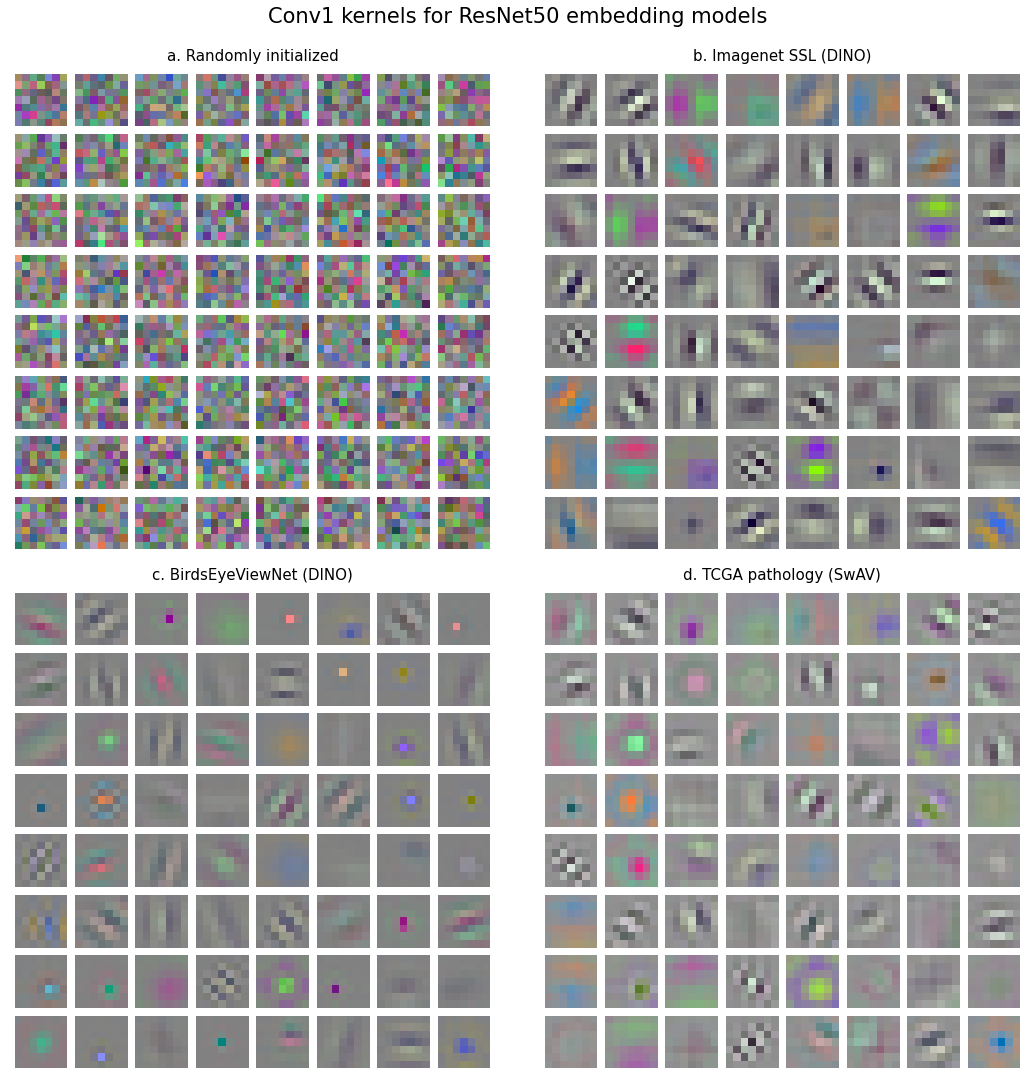

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

fig.suptitle('Conv1 kernels for ResNet50 embedding models', fontsize=21, y=1)

tensor_sat = visTensor(random_filter,axes[0,0], ch=0, allkernels=False)
tensor_sat = visTensor(reordered_filter_2,axes[0,1], ch=0, allkernels=False)
tensor_sat = visTensor(reordered_filter_1,axes[1,0], ch=0, allkernels=False)
tensor_sat = visTensor(reordered_filter_3,axes[1,1], ch=0, allkernels=False)

axes[0,0].set_title("a. Randomly initialized",size='15')
axes[0,1].set_title("b. Imagenet SSL (DINO)",size='15')
axes[1,0].set_title("c. BirdsEyeViewNet (DINO)",size='15')
axes[1,1].set_title("d. TCGA pathology (SwAV)",size='15')

axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])
axes[1,0].set_xticks([])
axes[1,0].set_yticks([])


for spine in axes[0,0].spines.values():
    spine.set_visible(False)
for spine in axes[1,1].spines.values():
    spine.set_visible(False)
for spine in axes[0,1].spines.values():
    spine.set_visible(False)
for spine in axes[1,0].spines.values():
    spine.set_visible(False)

fig.tight_layout()

fig.savefig('../figures/kernels.png', dpi=300 ,bbox_inches='tight', pad_inches=.1, facecolor='white')